In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

In [2]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

# Create Graph using Bipartite Projection on Arxiv Dataset

In [3]:
data = r'C:\Users\groov\PythonCode\100daysofnetworks\data\arxiv_network_science_data.csv'

df = pd.read_csv(data)

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

df = df[['authors', 'title']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

df.head()

,authors,title
0,Dustin Nguyen,Neural ODEs as a discovery tool to characteriz...
1,Yuan-Sen Ting,Neural ODEs as a discovery tool to characteriz...
2,Todd A. Thompson,Neural ODEs as a discovery tool to characteriz...
3,Sebastian Lopez,Neural ODEs as a discovery tool to characteriz...
4,Laura A. Lopez,Neural ODEs as a discovery tool to characteriz...


In [4]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(df, source='authors', target='title')
G = bipartite.projected_graph(B, df['authors'])

G = nx.k_core(G, 2) # no isolates or two-node groups

In [5]:
print(nx.info(G))

Graph with 59260 nodes and 302588 edges


# Community Detection + Community Analysis

There's two parts to what I am attempting today.
- I need to use community detection to identify communities in the network.
- I can then use network science and data science to identify interesting communities

By interesting, I mean not stars. I am looking for complex ecosystems. So, I will identify communities, then attempt to detect more complex ecosystems by using triangles and density.

## Community Detection

In [8]:
import community as community_louvain

partition = community_louvain.best_partition(G, resolution=0.01, random_state=1337) # 10 was good for this network

In [9]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

# remove junk; identify relevant communities

community_df['community'].value_counts()[0:20]

53      97
656     95
434     94
455     88
1851    83
315     83
629     82
259     82
427     81
243     80
5       78
402     75
898     73
410     72
311     72
43      71
1850    71
2049    70
1104    69
1362    68
Name: community, dtype: int64

In [19]:
community_node_counts = community_df['community'].value_counts()

community_size_df = pd.DataFrame(community_node_counts).reset_index()
community_size_df.columns = ['community', 'node_count']

# just to speed up this experiment
community_size_df = community_size_df[community_size_df['node_count'] > 10]

community_size_df.head()

,community,node_count
0,53,97
1,656,95
2,434,94
3,455,88
4,1851,83


In [20]:
community_size_df.shape

(1303, 2)

## Capture Community Context

In [23]:
community_df.head()

,node,community
0,Dustin Nguyen,0
1,Yuan-Sen Ting,0
2,Todd A. Thompson,0
3,Sebastian Lopez,0
4,Laura A. Lopez,0


In [22]:
community_size_df.head(1)

,community,node_count
0,53,97


In [31]:
def get_community_nodes(community_df, community):

    return sorted(community_df[community_df['community']==community]['node'].values)

In [79]:
def get_community_context(community_size_df, community_df, G):

    G = G.copy()

    communities = {}

    for row in community_size_df.iterrows():

        data = row[1]
        community = data['community']
        node_count = data['node_count']
        
        nodes = get_community_nodes(community_df, community)
        G_sub = G.subgraph(nodes)

        # starting with density today; will add on more context later
        density = nx.density(G_sub)
        
        communities[community] = {}

        communities[community]['G'] = G_sub
        communities[community]['density'] = density
        
    return communities

In [80]:
community_context_dict = get_community_context(community_size_df, community_df, G)

In [82]:
community_context_df = pd.DataFrame(community_context_dict).T.reset_index()
community_context_df.columns = ['community', 'G', 'density']

community_context_df.head()

,community,G,density
0,53,"(Chonho Lee, Dinh Thai Hoang, Guangyuan Liu, S...",0.075172
1,656,"(Avieli Haber, Tomislav Lipic, Gregorio D'Agos...",0.057559
2,434,"(Andrea Baldassarri, Bastien Dietemann, Hengxu...",0.057424
3,455,"(Jean M. Carlson, Lia Papadopoulos, Mathieu Ou...",0.073406
4,1851,"(Huaiyu Dai, Ye Hu, Emmanouil Panaousis, Imen ...",0.057596


<AxesSubplot:ylabel='Frequency'>

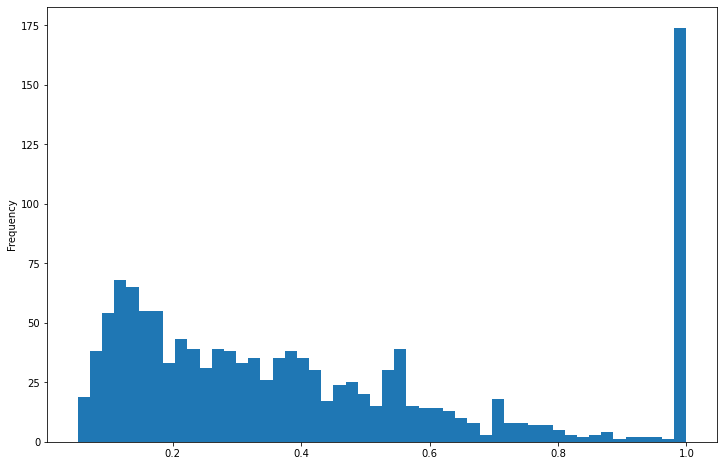

In [86]:
community_context_df['density'].plot.hist(bins=50, figsize=(12,8))

#### Investigate Communities

For this quick experiment, I want to just see subgraphs that have a density of 0.4 or above. 

But I want communities with a density of less than 0.8. I don't want fully connected communities or too densely connected.

In [110]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

In [111]:
mask = (community_context_df['density']>0.4) & (community_context_df['density']<0.8)

community_context_df[mask]['community'].values[0:10]

array([2541, 3773, 2757, 5469, 1352, 2494,  162, 1928, 2096, 1367],
      dtype=int64)

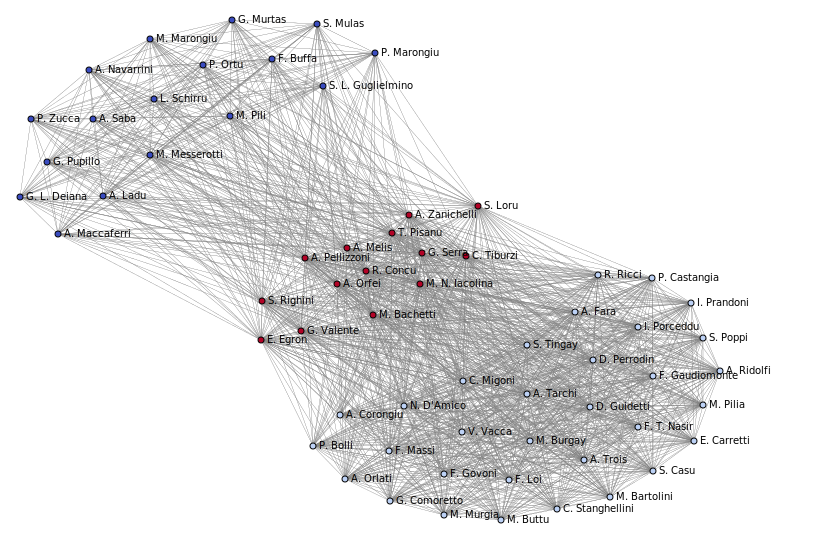

In [115]:
community = 2541

G_check = community_context_dict[community]['G']
draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

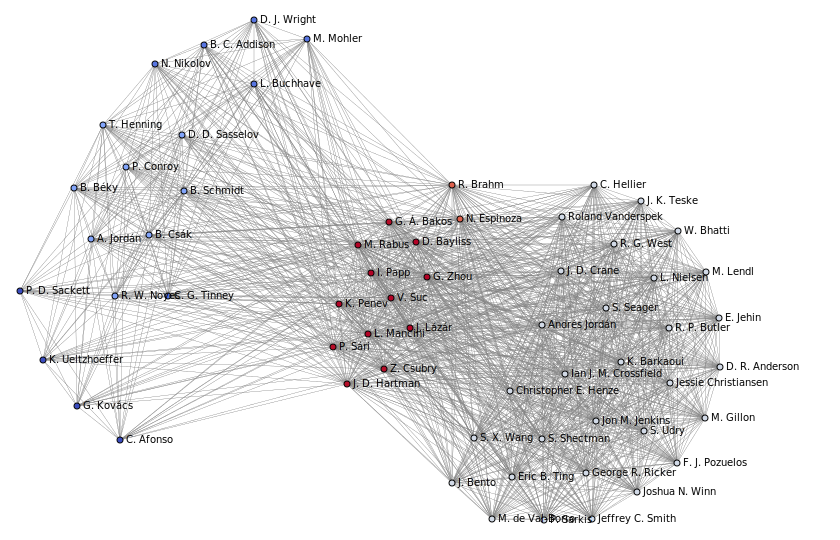

In [116]:
community = 3773

G_check = community_context_dict[community]['G']
draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

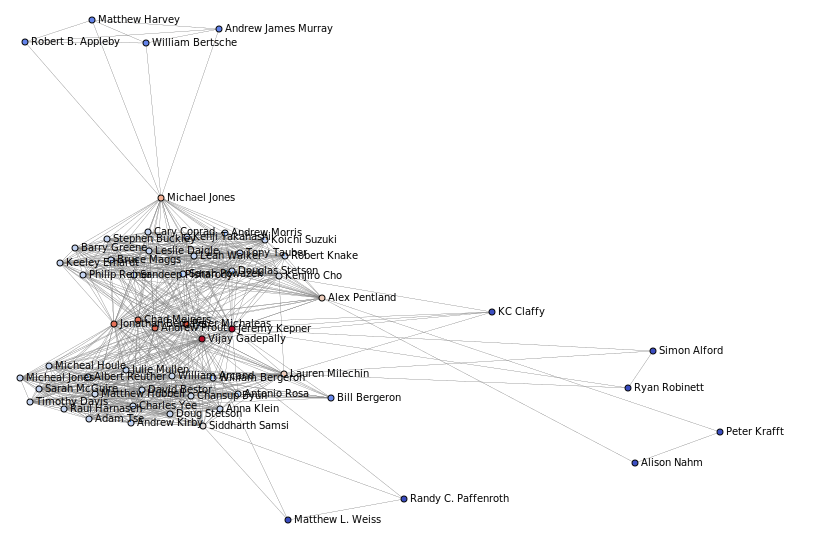

In [117]:
community = 2757

G_check = community_context_dict[community]['G']
draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

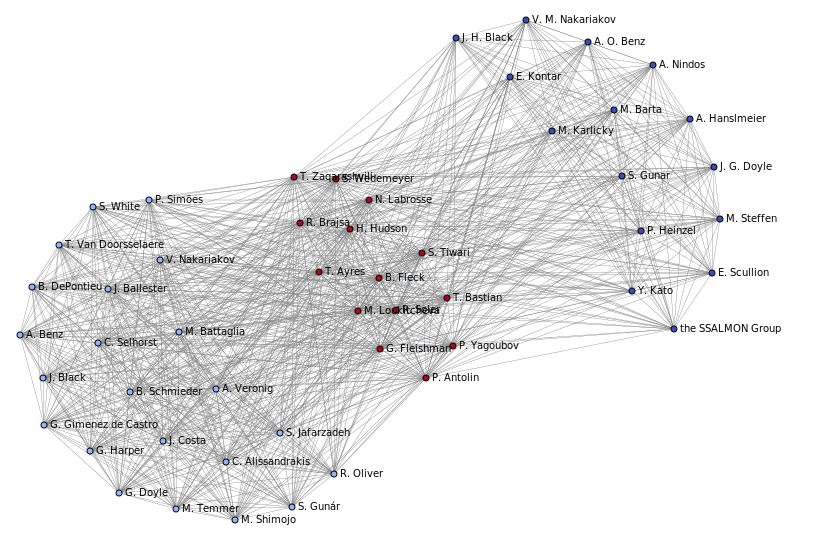

In [118]:
community = 5469

G_check = community_context_dict[community]['G']
draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

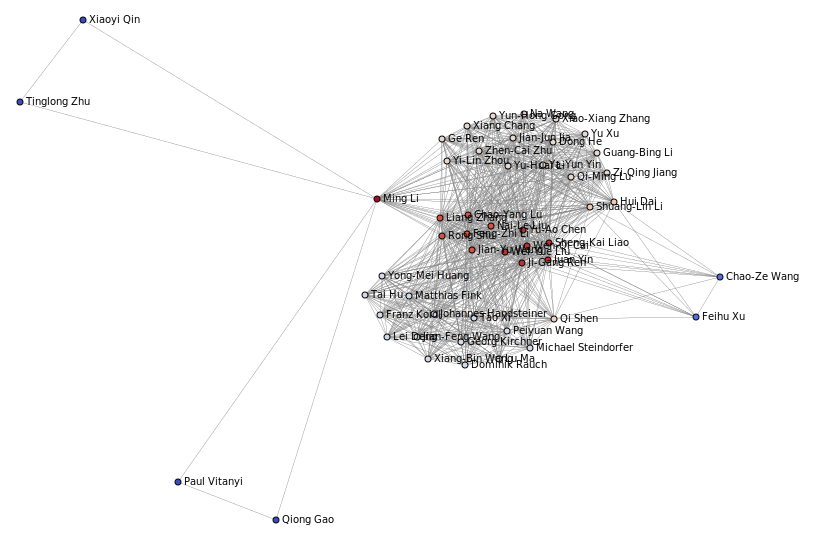

In [119]:
community = 1352

G_check = community_context_dict[community]['G']
draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

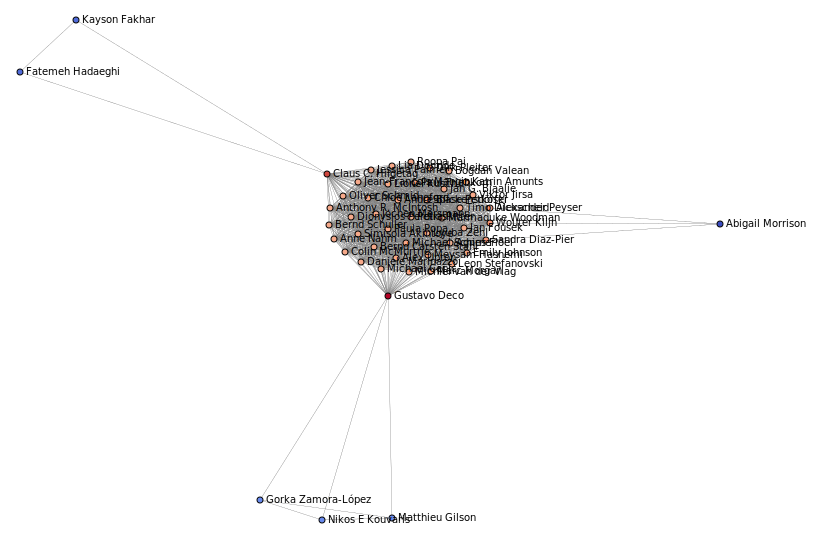

In [120]:
community = 2494

G_check = community_context_dict[community]['G']
draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)